In [1]:
# Setup

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import backend as K
from keras.layers import (Input, InputLayer, Dense, Lambda, Layer, Add, Multiply)
from keras.models import Model, Sequential
import pandas as pd
from tensorflow.keras import layers
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

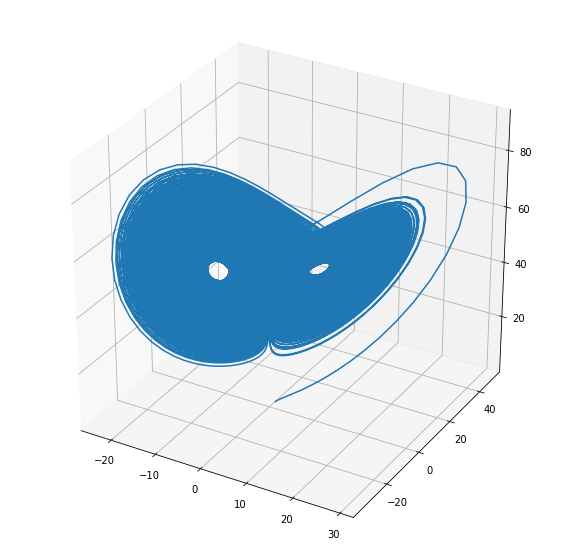

(299000, 3)
(2000, 100, 3)
(2000, 100, 3)


Text(0.5, 1.0, 'z')

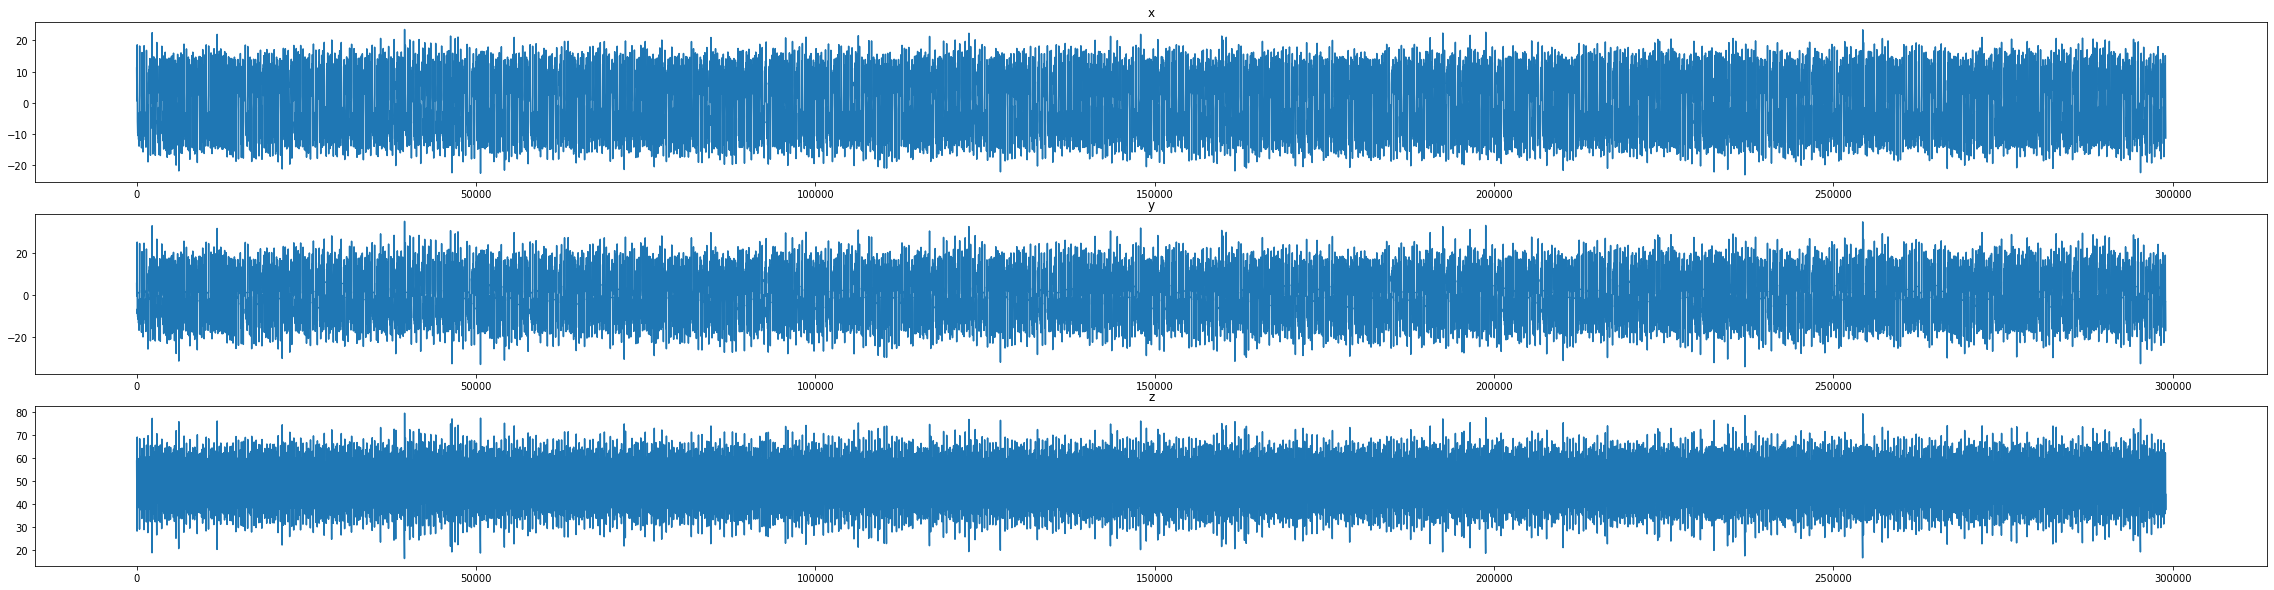

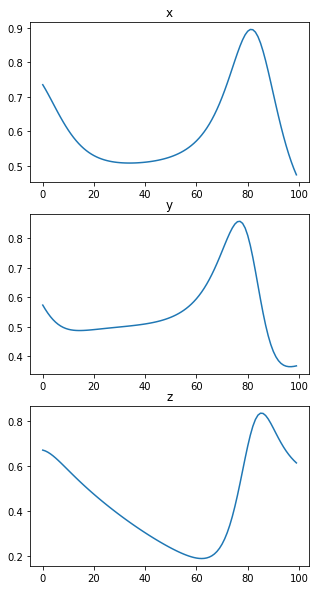

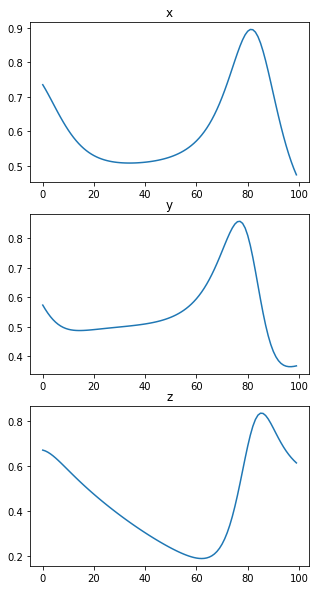

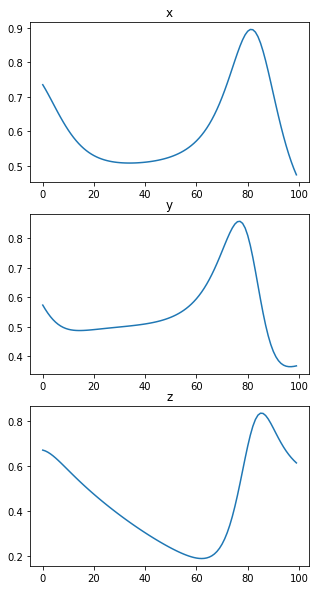

In [11]:
# Lorenz stimulation

rho = 50.0
sigma = 10.0
beta = 4.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 3000, 0.01)

states = odeint(f, state0, t)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

# Lorenz signals

positions = pd.DataFrame({'x':states[1000:,0],'y':states[1000:,1],'z':states[1000:,2]})
fig, axs = plt.subplots(3, figsize=(40,10))
axs[0].plot(positions['x'])
axs[0].set_title("x")
axs[1].plot(positions['y'])
axs[1].set_title("y")
axs[2].plot(positions['z'])
axs[2].set_title("z")

#Pre Processing

x = positions.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
positions_rescaled = pd.DataFrame(x_scaled, columns=positions.columns, index=positions.index)
print(positions_rescaled.shape)

# preprocessed signals

fig, axs = plt.subplots(3, figsize=(5,10))
axs[0].plot(positions_rescaled["x"][:100])
axs[0].set_title("x")
axs[1].plot(positions_rescaled["y"][:100])
axs[1].set_title("y")
axs[2].plot(positions_rescaled["z"][:100])
axs[2].set_title("z")


# Dataset with shape [#window, time(inside the window), channels(x,y,z)]
# Spliting the data

dataset = positions_rescaled.to_numpy()
dataset_train, dataset_test = train_test_split(dataset, test_size=99/299, shuffle=False)
dataset_train = np.array(np.vsplit(dataset_train,2000))
dataset_test = np.array(np.vsplit(dataset_train,2000))
dataset_test = np.reshape(dataset_test,(2000,100,3))
window = dataset_train.shape[1]
print(dataset_train.shape)
print(dataset_test.shape)


# Sample 0 of train_signals

fig, axs = plt.subplots(3, figsize=(5,10))
axs[0].plot(dataset_train[0,:,0])
axs[0].set_title("x")
axs[1].plot(dataset_train[0,:,1])
axs[1].set_title("y")
axs[2].plot(dataset_train[0,:,2])
axs[2].set_title("z")


# Sample 0 test_signals

fig, axs = plt.subplots(3, figsize=(5,10))
axs[0].plot(dataset_test[0,:,0])
axs[0].set_title("x")
axs[1].plot(dataset_test[0,:,1])
axs[1].set_title("y")
axs[2].plot(dataset_test[0,:,2])
axs[2].set_title("z")




In [13]:
"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



"""
## Build the Encoder

"""

latent_dim = 4
regularizer = keras.regularizers.l2(0.0001)
encoder_inputs = keras.Input(shape=(window, 3))
x = layers.Conv1D(32, 3, activation="relu", strides=1, padding="same",kernel_regularizer=regularizer)(encoder_inputs)
x = layers.MaxPool1D(pool_size= 2, strides= 1, padding='same')(x)
x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same",kernel_regularizer=regularizer)(x)
x = layers.MaxPool1D(pool_size= 2, strides= 1, padding='same')(x)
x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same",kernel_regularizer=regularizer)(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean",kernel_regularizer=regularizer)(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


"""
## Build the Decoder

"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(25 * 64, activation="relu",kernel_regularizer=regularizer)(latent_inputs)
x = layers.Reshape((25, 64))(x)
x = layers.Conv1DTranspose(64, 3, activation="relu", strides=2, padding="same",kernel_regularizer=regularizer)(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same",kernel_regularizer=regularizer)(x)
decoder_outputs = layers.Conv1DTranspose(3, 3, strides=1, activation="linear", padding="same", kernel_regularizer=regularizer)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


"""
## Define the VAE as a `Model` with a custom `train_step`
"""

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.n_epoches = 1
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            beta = self.n_epoches/12500
            total_loss = reconstruction_loss + beta * kl_loss 
             
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.n_epoches = self.n_epoches + 1
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def call(self,x):
        x = self.encoder(x)
        return self.decoder(x)




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 100, 32)      320         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 100, 32)      0           conv1d_9[0][0]                   
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 50, 64)       6208        max_pooling1d_6[0][0]            
____________________________________________________________________________________________

In [14]:
"""
## Train the VAE
"""
tf.config.run_functions_eagerly(True)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(lr=0.01))
callback = tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss', mode='auto', verbose=5, patience=3)
r = vae.fit(dataset_train, epochs=100, batch_size=64, callbacks=[callback])


Epoch 1/100
 1/32 [..............................] - ETA: 2s - loss: 26.5789 - reconstruction_loss: 26.5789 - kl_loss: 0.0081

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 2s 77ms/step - loss: 7.3033 - reconstruction_loss: 4.0177 - kl_loss: 0.5971
Epoch 2/100
32/32 [==============================] - 2s 77ms/step - loss: 2.2053 - reconstruction_loss: 2.1929 - kl_loss: 0.0774
Epoch 3/100
32/32 [==============================] - 3s 79ms/step - loss: 2.1450 - reconstruction_loss: 2.0779 - kl_loss: 2.2038
Epoch 4/100
32/32 [==============================] - 2s 77ms/step - loss: 1.8228 - reconstruction_loss: 1.5526 - kl_loss: 7.3791
Epoch 5/100
32/32 [==============================] - 2s 77ms/step - loss: 1.1290 - reconstruction_loss: 0.9014 - kl_loss: 8.8099
Epoch 6/100
32/32 [==============================] - 2s 76ms/step - loss: 0.6688 - reconstruction_loss: 0.4746 - kl_loss: 9.3095
Epoch 7/100
32/32 [==============================] - 2s 77ms/step - loss: 0.4683 - reconstruction_loss: 0.2775 - kl_loss: 8.7027
Epoch 8/100
32/32 [==============================] - 2s 76ms/step - loss: 0.3507 - reconstruction_loss: 0.184

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(2000, 100, 3)
The mean of MSE for X direction is 0.0006132885781755786
The mean of MSE for Y direction is 0.0005931944878378562
The mean of MSE for Z direction is 0.0011814368636033322


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


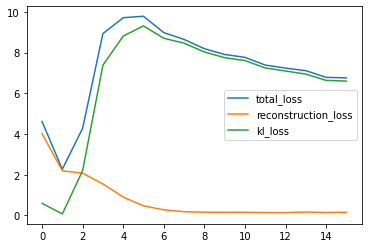

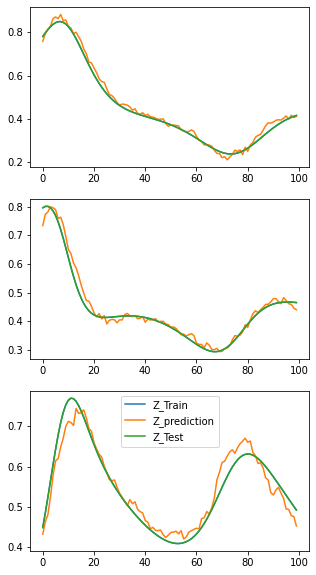

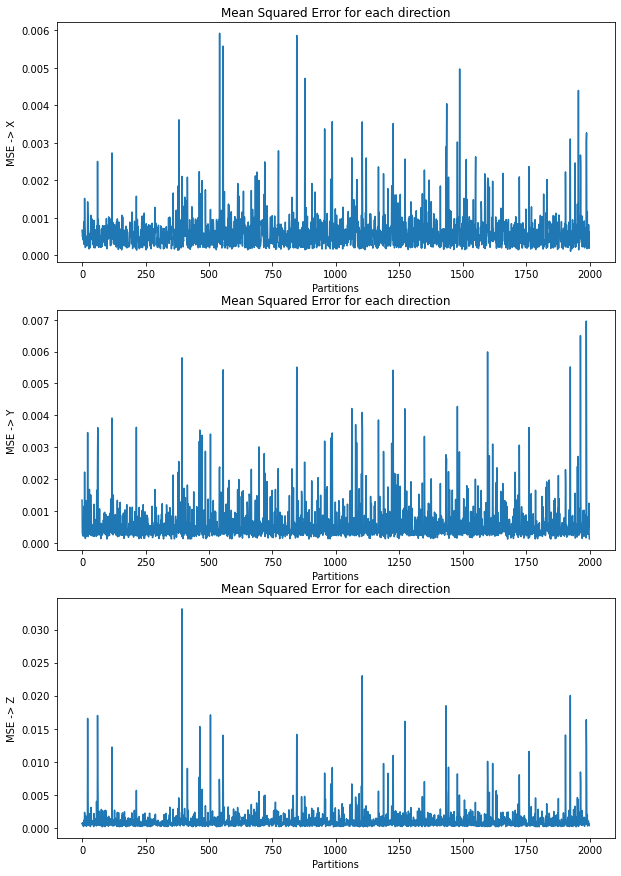

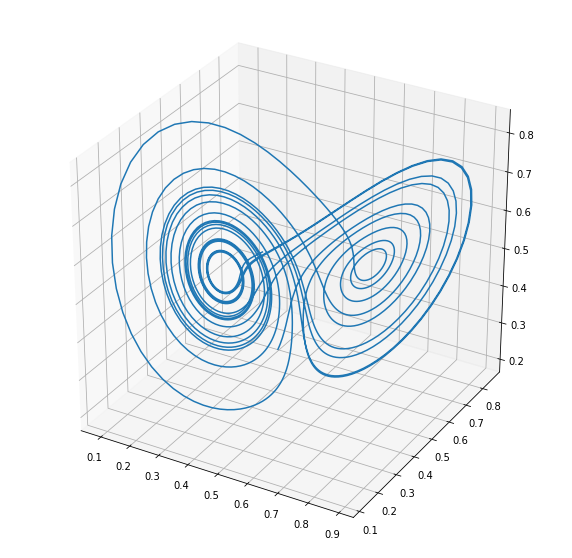

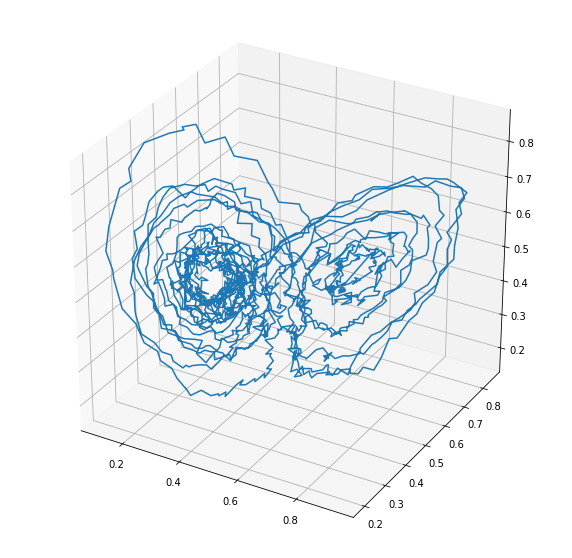

(99000, 3)
(990, 100, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


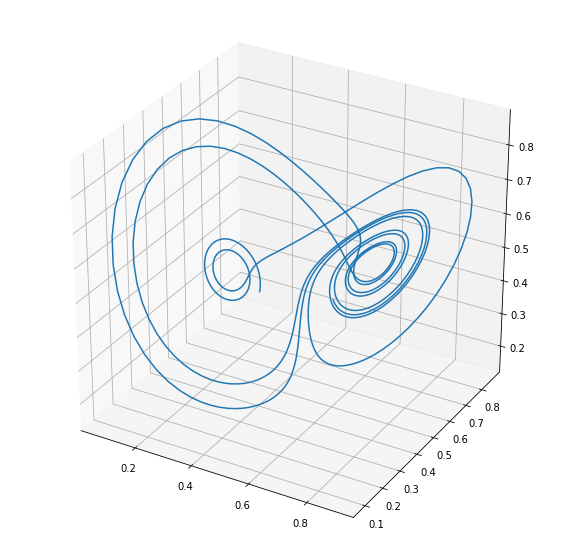

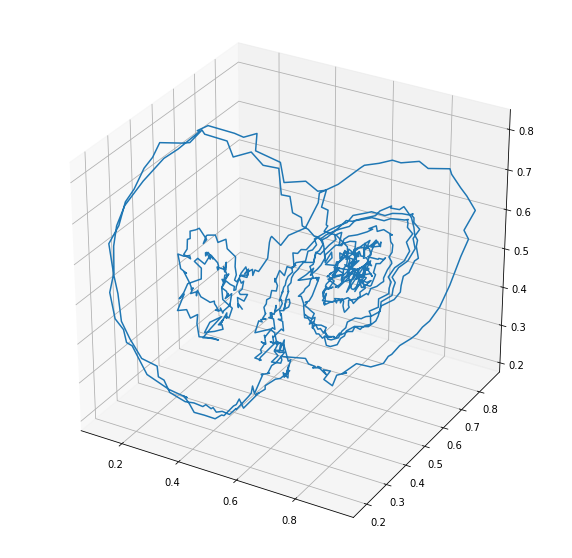

In [15]:

# Plotting Losses

df = pd.DataFrame(r.history)
df['total_loss'] = df['reconstruction_loss'] + df['kl_loss']

plt.plot(df['total_loss'],label='total_loss')
plt.plot(df['reconstruction_loss'],label='reconstruction_loss')
plt.plot(df['kl_loss'],label='kl_loss')
plt.legend()

# Plotting the results

z_mean, _, _ = vae.encoder.predict(dataset_test)
prediction = vae.decoder.predict(z_mean)
print(prediction.shape)
sample = 1900
fig, axs = plt.subplots(3, figsize=(5,10))
axs[0].plot(dataset_train[sample,:,0], label="X_Train")
axs[0].plot(prediction[sample,:,0], label="X_prediction")
axs[0].plot(dataset_test[sample,:,0], label="X_Test")
axs[1].plot(dataset_train[sample,:,1], label="Y_Train")
axs[1].plot(prediction[sample,:,1], label="Y_prediction")
axs[1].plot(dataset_test[sample,:,1], label="Y_Test")
axs[2].plot(dataset_train[sample,:,2], label="Z_Train")
axs[2].plot(prediction[sample,:,2], label="Z_prediction")
axs[2].plot(dataset_test[sample,:,2], label="Z_Test")

plt.legend()


from sklearn.metrics import mean_squared_error

mse_mat = np.ndarray((2000,3))
for i in range(0,2000):
  for j in range(3):
    mse_mat[i,j] = mean_squared_error(dataset_test[i,:,j],prediction[i,:,j])

print('The mean of MSE for X direction is',np.mean(mse_mat[:,0]))
print('The mean of MSE for Y direction is',np.mean(mse_mat[:,1]))
print('The mean of MSE for Z direction is',np.mean(mse_mat[:,2]))


fig, axs = plt.subplots(3, figsize=(10,15))
axs[0].plot(mse_mat[:,0])
axs[0].set_title('Mean Squared Error for each direction')
axs[0].set_xlabel('Partitions')
axs[0].set_ylabel('MSE -> X')
axs[1].plot(mse_mat[:,1])
axs[1].set_title('Mean Squared Error for each direction')
axs[1].set_xlabel('Partitions')
axs[1].set_ylabel('MSE -> Y')
axs[2].plot(mse_mat[:,2])
axs[2].set_title('Mean Squared Error for each direction')
axs[2].set_xlabel('Partitions')
axs[2].set_ylabel('MSE -> Z')



### plot the test data with the output of CNN

z_mean, _, _ = vae.encoder.predict(dataset_test)
prediction = vae.decoder.predict(z_mean)
prediction = np.reshape(prediction,(200000,3))
data = np.reshape(dataset_train,(200000,3))


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
ax.plot(data[100:2000, 0], data[100:2000, 1], data[100:2000, 2])
plt.draw()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
ax.plot(prediction[100:2000, 0], prediction[100:2000, 1], prediction[100:2000, 2])
plt.draw()
plt.show()


# New Lorenz stimulation

rho = 50.0
sigma = 10.0
beta = 4.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [10.0, 10.0, 10.0]
t = np.arange(4000, 5000, 0.01)

states = odeint(f, state0, t)

positions = pd.DataFrame({'x':states[1000:,0],'y':states[1000:,1],'z':states[1000:,2]})

#Pre Processing

x = positions.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
positions_rescaled = pd.DataFrame(x_scaled, columns=positions.columns, index=positions.index)
print(positions_rescaled.shape)

# Dataset with shape [#window, time(inside the window), channels(x,y,z)]

dataset = positions_rescaled.to_numpy()
dataset = np.array(np.vsplit(dataset,990))
window = dataset.shape[1]
print(dataset.shape)


### plot the new data with the output of CNN

z_mean, _, _ = vae.encoder.predict(dataset)
prediction = vae.decoder.predict(z_mean)
prediction = np.reshape(prediction,(99000,3))
data = np.reshape(dataset,(99000,3))


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
ax.plot(data[10:900, 0], data[10:900, 1], data[10:900, 2])
plt.draw()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
ax.plot(prediction[10:900, 0], prediction[10:900, 1], prediction[10:900, 2])
plt.draw()
plt.show()